In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)


In [76]:
import torch
import jupyter_black
import lightning as pl
import numpy as np
import cv2 as cv
import segmentation_models_pytorch as smp
from data import FakeBacteriasDataModule
from models import BacteriasBinarySegmentation
from lightning.pytorch.loggers import TensorBoardLogger
from utils import show_images, read_images, get_bacterias_binary_segmentation_checkpoint
from constants import ORIGINAL_IMAGES_PATH
from torchvision import transforms

jupyter_black.load()
torch.set_float32_matmul_precision("high")


Image shape: torch.Size([1, 64, 64])


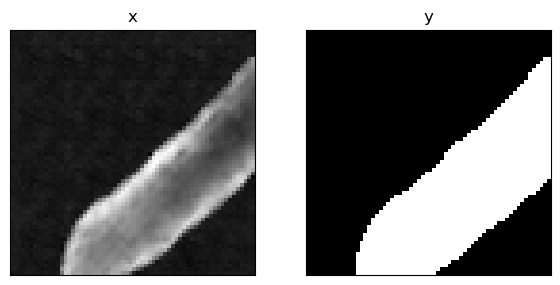

In [3]:
module = FakeBacteriasDataModule(
    batch_size=1, num_workers=0, shuffle=True, train_size=0.9, val_size=0.1, limit=3000
)
module.setup("fit")
loader = module.train_dataloader()
for i, batch in enumerate(loader):
    x, y = batch
    print(f"Image shape: {x[0].shape}")
    show_images(
        [
            (x[0].detach().numpy().squeeze(), "x"),
            (y[0].detach().numpy().squeeze(), "y"),
        ],
        size_inches=(7, 7),
    )
    break


In [4]:
bacterias_binary_segmentation_model = BacteriasBinarySegmentation.load_from_checkpoint(
    get_bacterias_binary_segmentation_checkpoint(version=0, epoch=4, step=13500)
)


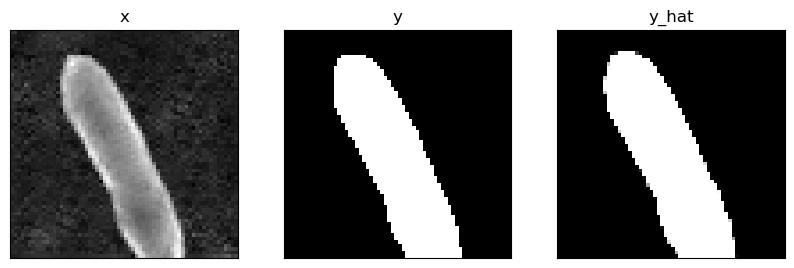

In [174]:
batch = next(iter(module.val_dataloader()))
with torch.no_grad():
    bacterias_binary_segmentation_model.eval()
    x, y = batch
    y_hat = bacterias_binary_segmentation_model(x)
show_images(
    [
        (x.detach().numpy().squeeze(), "x"),
        (y.detach().numpy().squeeze(), "y"),
        (y_hat.detach().numpy().squeeze(), "y_hat"),
    ],
    grid=(1, 3),
)

Orig image shape is (890, 1280, 3)


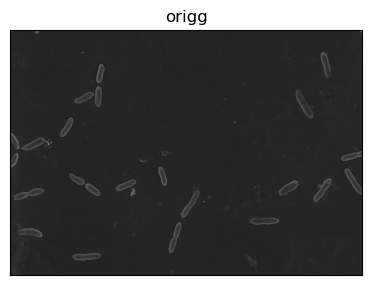

In [167]:
orig_images = read_images(ORIGINAL_IMAGES_PATH)
idx = np.random.randint(0, len(orig_images))
orig_image = orig_images[idx]
show_images([(orig_image, "origg")])
print(f"Orig image shape is {orig_image.shape}")

In [168]:
def concat_tile(im_list_2d):
    return cv.vconcat([cv.hconcat(im_list_h) for im_list_h in im_list_2d])  # type: ignore


def get_mask(tile: np.ndarray) -> np.ndarray:
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
        ]
    )
    with torch.no_grad():
        bacterias_binary_segmentation_model.eval()
        tile = transform(tile).reshape((1, 1, *tile.shape[:2]))
        mask = bacterias_binary_segmentation_model(tile)
        return mask.detach().numpy().squeeze()


def get_image_mask(image: np.ndarray, tile_size: int = 32):
    h, w, _ = image.shape
    orig = []
    mask = []
    for i in range(h // tile_size):
        orig_row = []
        mask_row = []
        for j in range(w // tile_size):
            tile = image[
                tile_size * i : tile_size * (i + 1), tile_size * j : tile_size * (j + 1)
            ]
            orig_row.append(tile)
            mask_row.append(get_mask(tile))
        orig.append(orig_row)
        mask.append(mask_row)
    orig = concat_tile(orig)
    mask = concat_tile(mask)
    return orig, mask

In [169]:
_, mask = get_image_mask(orig_image, tile_size=512)
images = [
    (orig_image, "orig"),
]
tile_sizes = [64, 128, 256, 512]
for _, tile_size in enumerate(tile_sizes):
    _, mask = get_image_mask(orig_image, tile_size=tile_size)
    images.append((mask, f"{tile_size}x{tile_size}"))
images.append((get_mask(orig_image[:864, :]), "full"))

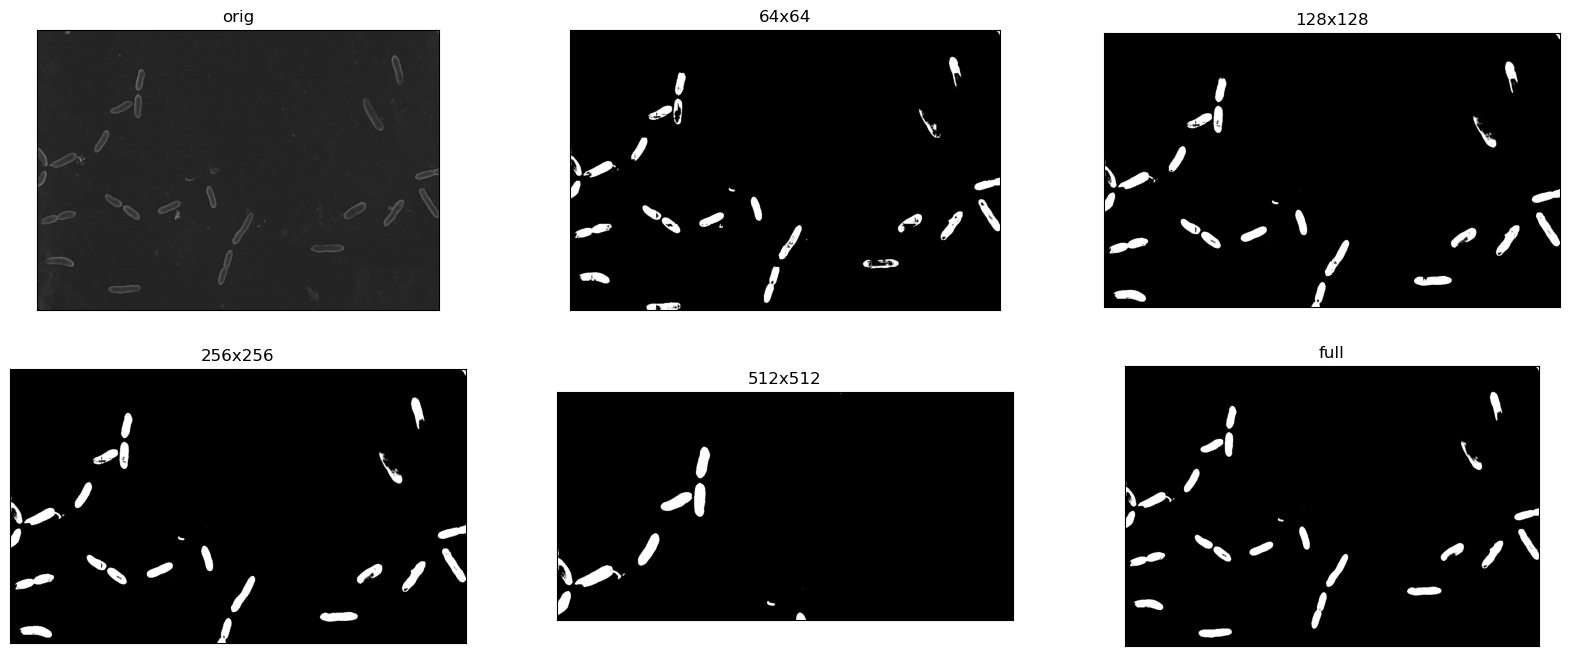

In [170]:
show_images(images, grid=(2, 3), size_inches=(20, 8))